In [1]:
"""
This notebook takes the raw consumption data and makes the dataframe for imputation.
In this df, rows with more than 30% missing cols in the 0 class are discarded.
"""

'\nThis notebook takes the raw consumption data and makes the dataframe for imputation.\nIn this df, rows with more than 30% missing cols in the 0 class are discarded.\n'

In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import pandas as po
from tqdm import tqdm
from math import isinf 
import multiprocessing
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import array, zeros, full, argmin, inf, ndim

In [3]:
from filepaths import fp

In [6]:
df = po.read_csv('../data/processed/EnergyConsumption_normalized.csv') #.sample(frac=1).reset_index(drop = True) # shuffle df so that classes are evenly distributed in train-val-test

In [8]:
num_zeros = []
for i in tqdm(range(len(df))):
    num_zeros.append(df.iloc[i][1:].to_list().count(0))

100%|██████████| 42372/42372 [00:29<00:00, 1418.11it/s]


In [9]:
df['num_zeros'] = num_zeros

In [11]:
def find_gaps(x):
    seq = False
    missing_seqs = []
    seq_start_idx = -1
    for i in range(len(x)):
        if seq == False and x[i] == 0:
            seq = True
            seq_start_idx = i
        
        elif seq == True and x[i] != 0:
            seq = False
            if seq_start_idx == -1:
                raise
            missing_seqs.append((seq_start_idx, i))
            seq_start_idx = -1
    
    return missing_seqs

In [12]:
def remove_micro_gaps(x, maxlen=5):
    x_filled = x.copy()
    missing_seqs = find_gaps(x)
    
    for seq in missing_seqs:
        if (seq[1] - seq[0]) <= maxlen:
            len_gap = seq[1] - seq[0]
            if seq[0]-len_gap < 0 or seq[1]+len_gap>len(x):
                continue
            interpfunk = interp1d(list(range(seq[0]-len_gap, seq[0])) + list(range(seq[1], seq[1]+len_gap)), x[seq[0]-len_gap:seq[0]] + x[seq[1]:seq[1]+len_gap]) 
            
            for i in range(len_gap):
                x_filled[seq[0]+i] = interpfunk(seq[0]+i).item()
            
    return x_filled

In [25]:
def tiny_impute(i):
    x = df.iloc[i][:-2].to_list()
    return remove_micro_gaps(x)    

In [26]:
p = multiprocessing.Pool() 
new_rows = list(tqdm(p.imap(tiny_impute, list(range(len(df)))), total=len(df)))

100%|██████████| 42372/42372 [00:16<00:00, 2506.75it/s]


In [27]:
df_interp = po.DataFrame(new_rows)

In [30]:
df_interp.columns = df.columns[:-2]
df_interp

,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,2014/1/9,2014/1/10,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002973,0.000000,...,0.000631,0.000727,0.000597,0.000798,0.000439,0.000576,0.000621,0.000535,0.000734,0.000675
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000963,0.001226,0.001004,0.001140,0.001091,0.000897,0.000909,0.000965,0.001091,0.001362
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000234,0.000000,...,0.001127,0.001362,0.001273,0.001249,0.001570,0.001370,0.001199,0.001366,0.001159,0.001173
4,0.000874,0.002256,0.002614,0.000586,0.000744,0.001283,0.000976,0.001038,0.000799,0.000862,...,0.001250,0.000921,0.000625,0.000512,0.000489,0.000443,0.000502,0.000772,0.000790,0.000873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000523,0.000000,...,0.000288,0.000279,0.000203,0.000252,0.000240,0.000186,0.000170,0.000241,0.000288,0.000254
42368,0.000814,0.000000,0.000000,0.001009,0.001246,0.001393,0.000633,0.001139,0.001286,0.001107,...,0.000338,0.000596,0.000230,0.000432,0.000290,0.000306,0.000248,0.000441,0.000485,0.000477
42369,0.000175,0.000464,0.000344,0.000173,0.000317,0.000331,0.000184,0.000197,0.000279,0.000212,...,0.000087,0.000055,0.000048,0.000046,0.000039,0.000034,0.000053,0.000047,0.000031,0.000065
42370,0.005090,0.006060,0.007210,0.003032,0.003461,0.004192,0.003684,0.006765,0.002794,0.003490,...,0.001376,0.001485,0.000962,0.000870,0.000962,0.000735,0.000816,0.000933,0.001068,0.001040


In [31]:
num_zeros = []
for i in tqdm(range(len(df_interp))):
    num_zeros.append(df_interp.iloc[i].to_list().count(0))

100%|██████████| 42372/42372 [00:06<00:00, 6804.60it/s]


In [32]:
df_interp['num_zeros'] = num_zeros

In [33]:
df_interp['num_zeros']

0         431
1        1034
2         806
3         547
4           0
         ... 
42367     212
42368      50
42369      46
42370     127
42371     729
Name: num_zeros, Length: 42372, dtype: int64

In [34]:
df['num_zeros']

0         433
1        1033
2         809
3         551
4           2
         ... 
42367     222
42368      76
42369      52
42370     129
42371     729
Name: num_zeros, Length: 42372, dtype: int64

In [37]:
df_interp['FLAG'] = df['FLAG']

In [38]:
df_0 = df_interp[df_interp['FLAG'] == 0].reset_index(drop=True) #.sort_values('num_zeros')[:3615]
df_1 = df_interp[df_interp['FLAG'] == 1].reset_index(drop=True)

In [39]:
len(df_0)

38757

In [40]:
len(df_1)

3615

In [41]:
# Taking the part of the dataframe with less than 30% missing values for imputation
df_0 = df_0[df_0['num_zeros'] < 0.3*len(df_0.columns)]
df_0

,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,2014/1/9,2014/1/10,...,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31,num_zeros,FLAG
1,0.002254,0.005136,0.004495,0.002910,0.003274,0.001904,0.002807,0.003043,0.002398,0.002320,...,0.000850,0.000796,0.001123,0.000936,0.000911,0.000732,0.001308,0.001220,126,0
4,0.000000,0.003660,0.002748,0.001836,0.002183,0.002530,0.002877,0.003223,0.003537,0.003851,...,0.001167,0.001115,0.001040,0.001009,0.000828,0.001159,0.001791,0.002237,224,0
5,0.000000,0.000000,0.000000,0.002016,0.002330,0.002644,0.002957,0.003271,0.003661,0.004050,...,0.000302,0.000379,0.000462,0.000320,0.000431,0.000534,0.000506,0.000551,39,0
7,0.000000,0.000000,0.000000,0.000000,0.001757,0.001766,0.001774,0.000000,0.000000,0.000000,...,0.000479,0.000564,0.000588,0.000711,0.000735,0.000472,0.000329,0.000579,64,0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000145,0.000167,0.000154,0.000120,0.000126,0.000146,0.000211,0.000196,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000375,0.000000,...,0.000029,0.000072,0.000048,0.000054,0.000043,0.000038,0.000062,0.000056,292,0
38752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000523,0.000000,...,0.000203,0.000252,0.000240,0.000186,0.000170,0.000241,0.000288,0.000254,212,0
38753,0.000814,0.000000,0.000000,0.001009,0.001246,0.001393,0.000633,0.001139,0.001286,0.001107,...,0.000230,0.000432,0.000290,0.000306,0.000248,0.000441,0.000485,0.000477,50,0
38754,0.000175,0.000464,0.000344,0.000173,0.000317,0.000331,0.000184,0.000197,0.000279,0.000212,...,0.000048,0.000046,0.000039,0.000034,0.000053,0.000047,0.000031,0.000065,46,0


In [42]:
df_imp = po.concat([df_0, df_1], axis=0, ignore_index=True).sample(frac=1).reset_index(drop=True)
df_imp

,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,2014/1/9,2014/1/10,...,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31,num_zeros,FLAG
0,0.003306,0.005092,0.004084,0.002153,0.002118,0.002233,0.002193,0.002183,0.002754,0.002912,...,0.000711,0.000954,0.000763,0.000935,0.000706,0.000838,0.001079,0.001154,0,0
1,0.002839,0.002636,0.001719,0.000802,0.001172,0.001789,0.001347,0.001796,0.001463,0.001856,...,0.000536,0.000574,0.000536,0.000528,0.000357,0.000219,0.000523,0.000632,160,0
2,0.001043,0.001152,0.001260,0.000765,0.001356,0.001947,0.001788,0.002352,0.001590,0.002390,...,0.000389,0.000409,0.000522,0.000340,0.000028,0.000030,0.000123,0.000136,0,0
3,0.003647,0.004900,0.003473,0.002046,0.002234,0.002423,0.002611,0.004230,0.000000,0.000000,...,0.000921,0.000646,0.001120,0.000639,0.000595,0.000465,0.000907,0.000368,106,0
4,0.004756,0.004716,0.004660,0.002529,0.002707,0.003427,0.002706,0.003627,0.002892,0.003371,...,0.000833,0.001026,0.000962,0.000762,0.000782,0.000791,0.000898,0.001173,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24267,0.002694,0.002704,0.003149,0.001000,0.001347,0.001487,0.001405,0.002146,0.001875,0.001775,...,0.000437,0.000709,0.000591,0.000555,0.000415,0.000524,0.000627,0.000546,0,0
24268,0.000648,0.000892,0.000438,0.000416,0.000146,0.000177,0.000132,0.000161,0.000161,0.000514,...,0.000110,0.000206,0.000345,0.000106,0.000132,0.000133,0.000124,0.000172,0,1
24269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.000009,...,0.000338,0.000378,0.000241,0.000302,0.000230,0.000325,0.000367,0.000459,199,0
24270,0.000630,0.001240,0.001197,0.000547,0.000635,0.000717,0.000724,0.000964,0.000711,0.000819,...,0.000298,0.000466,0.000352,0.000280,0.000278,0.000308,0.000280,0.000481,0,0


In [43]:
df_imp['FLAG'].value_counts()

0    20657
1     3615
Name: FLAG, dtype: int64

In [44]:
df_imp.to_csv('../data/processed/imputation/imp_raw.csv', index=False)

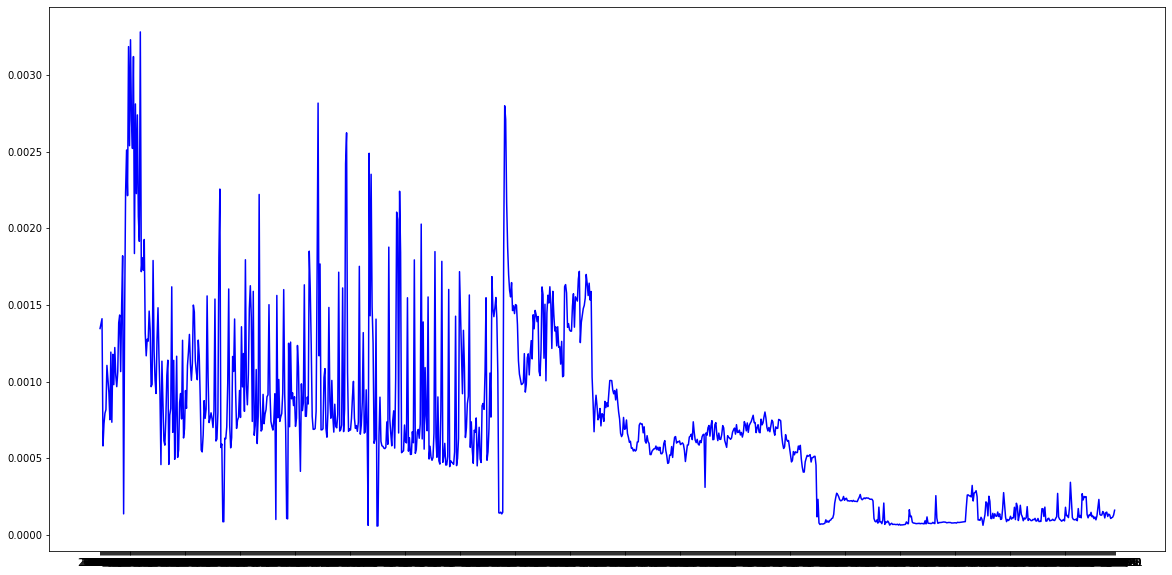

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(df_imp.iloc[24][:-2], color='blue')